# 📈 ASTP – Projeto Final
## Previsão de atrasos e cancelamentos de voos nos Estados Unidos, com base em fatores meteorológicos

### 👥 Grupo XX
- **Pedro Fonte Santa**, nº 105306  
- **Rafael Alexandre Dias Andorinha**, nº 131000  
- **Vasco Marques**, nº 87526

---

📅 **Data de entrega:** 19 de maio de 2025  

**Objetivo deste Notebook**: Este notebook tem como objetivo realizar a **análise exploratória das séries temporais de atrasos e cancelamentos de voos** nos Estados Unidos, entre os anos de 2018 e 2022.

### Objetivos específicos:
- Visualizar o comportamento temporal das duas séries
- Identificar padrões como **tendência, sazonalidade e outliers**
- Verificar propriedades estatísticas, incluindo:
  - **Normalidade** da distribuição
  - **Estacionariedade** (ADF e KPSS)
  - **Autocorrelação** (ACF e PACF)

Esta análise é essencial para compreender a natureza dos dados antes da modelação clássica e com deep learning, e serve de base para investigações adicionais como a análise de causalidade de Granger.

---

### 🗂️ Datasets:
- [Previsão de estados de Voos (Kaggle)](https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022/data?select=raw)  
- [Eventos Climáticos nos EUA (Kaggle)](https://www.kaggle.com/datasets/sobhanmoosavi/us-weather-events/data)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
from statsmodels.stats.diagnostic import breaks_cusumolsresid

from scipy.stats import normaltest

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (14,6)

### 📂 Carregamento e Visualização dos Dados

In [2]:
caminho_arquivo = "../../data/flight-delay-dataset-2018-2022_Final.csv"

# Carregar o dataset
df = pd.read_csv(caminho_arquivo, parse_dates=["FlightDate"])

# Mostrar as primeiras linhas
df.head()

,FlightDate,Atrasos,Cancelamentos
0,2018-01-01,4331,129
1,2018-01-02,4277,110
2,2018-01-03,3576,449
3,2018-01-04,2043,3001
4,2018-01-05,3525,1007


In [3]:
# Mostrar as ultimas linhas
df.tail()

,FlightDate,Atrasos,Cancelamentos
1668,2022-07-27,4454,212
1669,2022-07-28,4830,610
1670,2022-07-29,5049,294
1671,2022-07-30,4078,256
1672,2022-07-31,4907,482


> Vamos agregar os dados por dia: Número de voos atrasados (>15 min) e número de voos cancelados por dia

In [4]:
series_diarias = pd.read_csv(caminho_arquivo, parse_dates=["FlightDate"])
series_diarias = series_diarias.set_index("FlightDate")

# Ver as primeiras linhas
series_diarias.head()

,Atrasos,Cancelamentos
FlightDate,,
2018-01-01,4331,129
2018-01-02,4277,110
2018-01-03,3576,449
2018-01-04,2043,3001
2018-01-05,3525,1007


In [5]:
series_diarias.tail()

,Atrasos,Cancelamentos
FlightDate,,
2022-07-27,4454,212
2022-07-28,4830,610
2022-07-29,5049,294
2022-07-30,4078,256
2022-07-31,4907,482


### 📈 Análise Inicial: Resumo Estatístico e Distribuição dos Dados

In [6]:
# Resumo estatístico das séries
print("Resumo Estatístico - Atrasos Diários")
print(series_diarias["Atrasos"].describe())
print("\nResumo Estatístico - Cancelamentos Diários")
print(series_diarias["Cancelamentos"].describe())

Resumo Estatístico - Atrasos Diários
count    1673.000000
mean     2935.980873
std      1701.152705
min       159.000000
25%      1651.000000
50%      2794.000000
75%      4105.000000
max      8745.000000
Name: Atrasos, dtype: float64

Resumo Estatístico - Cancelamentos Diários
count     1673.000000
mean       464.594740
std       1077.414807
min          5.000000
25%         68.000000
50%        174.000000
75%        410.000000
max      11808.000000
Name: Cancelamentos, dtype: float64


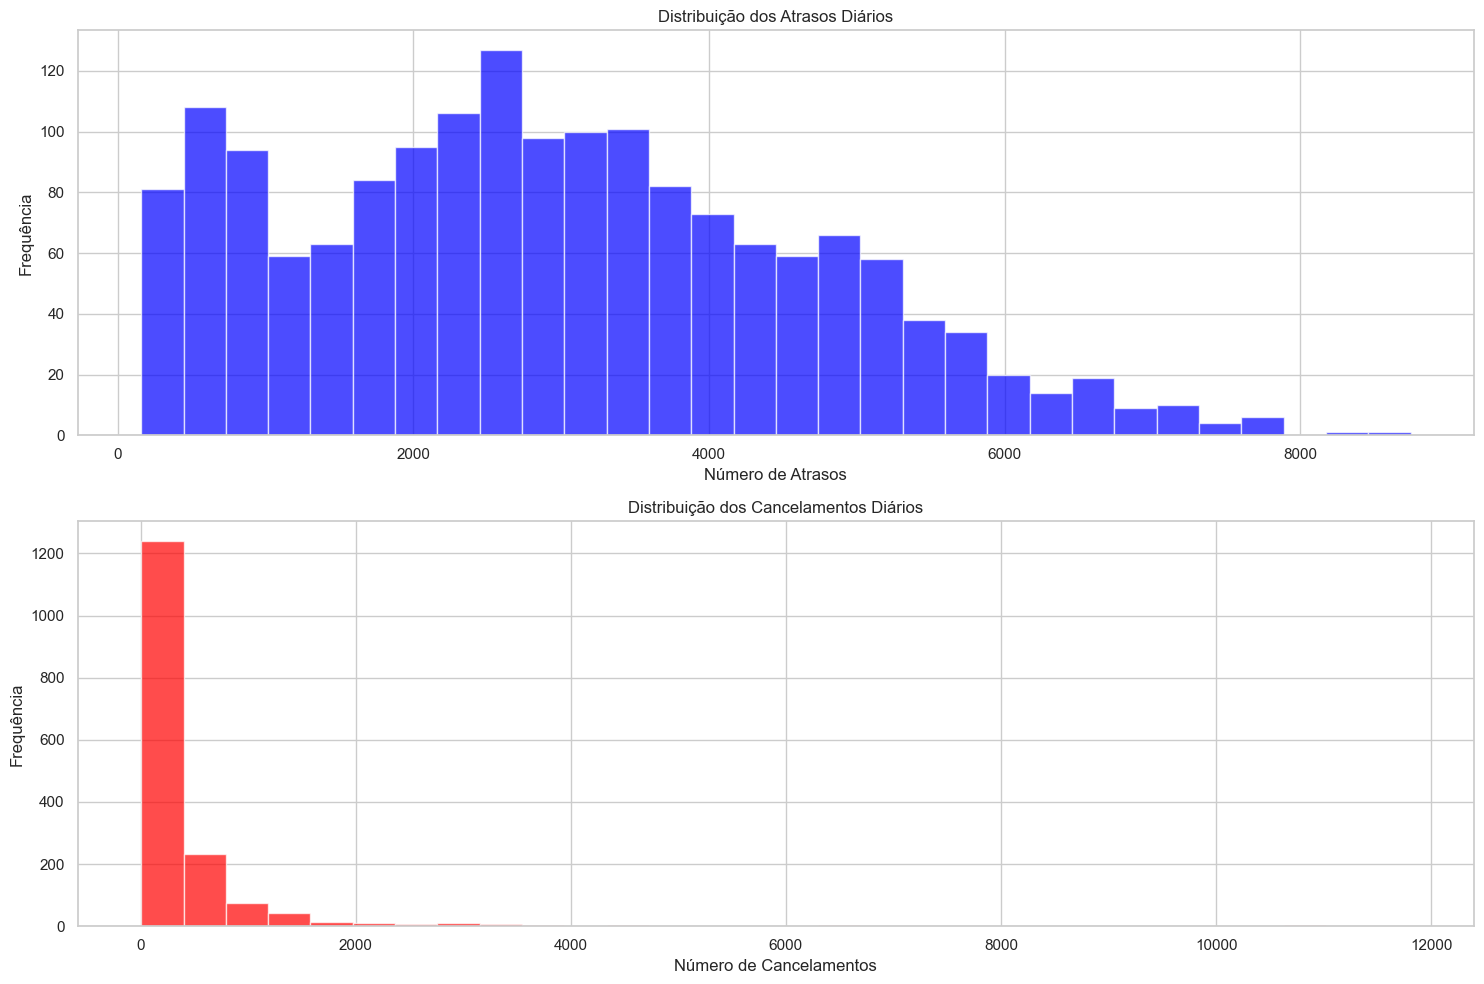

In [7]:
# Histograma das Séries
fig, axs = plt.subplots(2, 1, figsize=(15,10))

# Histograma de Atrasos
axs[0].hist(series_diarias["Atrasos"], bins=30, color='blue', alpha=0.7)
axs[0].set_title("Distribuição dos Atrasos Diários")
axs[0].set_xlabel("Número de Atrasos")
axs[0].set_ylabel("Frequência")

# Histograma de Cancelamentos
axs[1].hist(series_diarias["Cancelamentos"], bins=30, color='red', alpha=0.7)
axs[1].set_title("Distribuição dos Cancelamentos Diários")
axs[1].set_xlabel("Número de Cancelamentos")
axs[1].set_ylabel("Frequência")

plt.tight_layout()
plt.show()

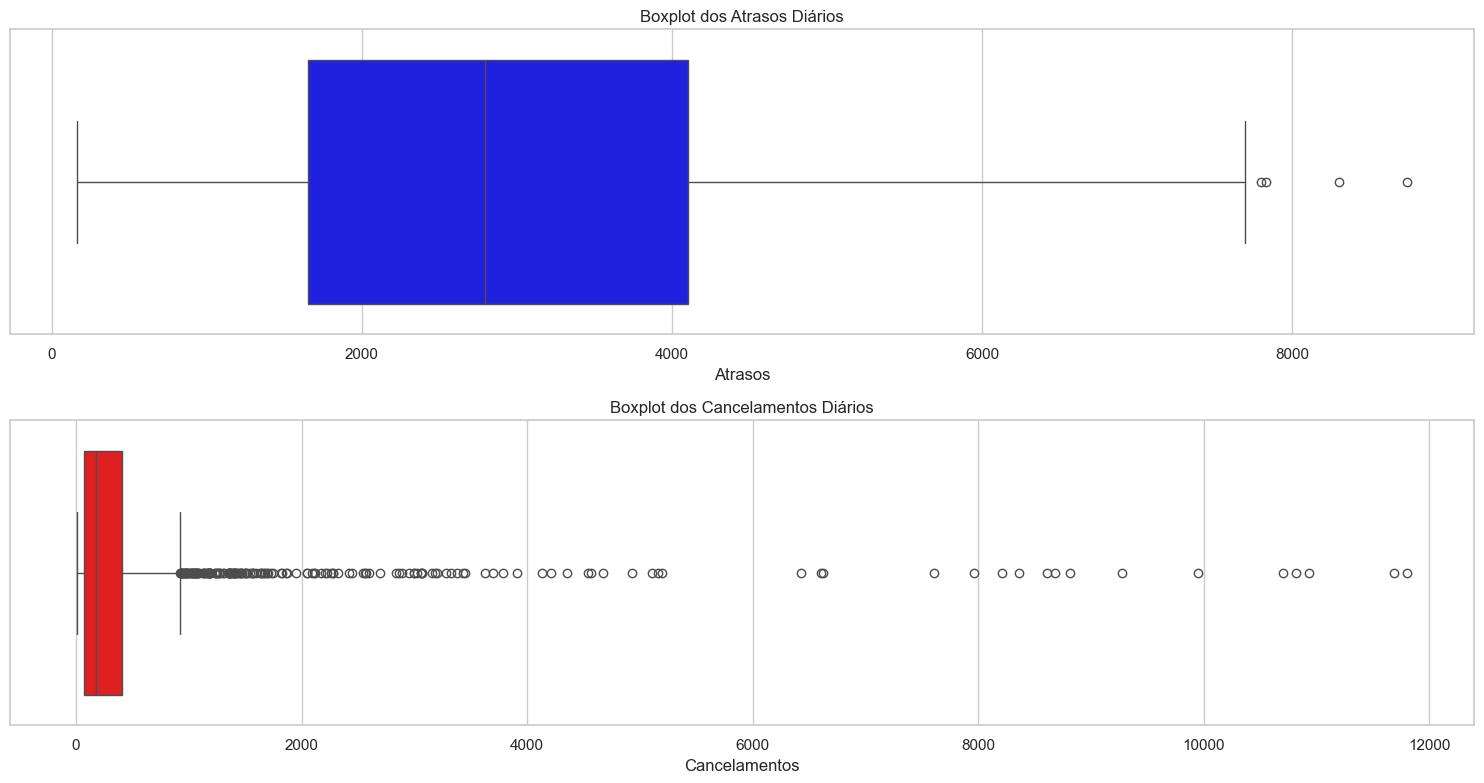

In [8]:
# Boxplots para identificação de outliers
fig, axs = plt.subplots(2, 1, figsize=(15,8))

# Boxplot Atrasos
sns.boxplot(x=series_diarias["Atrasos"], ax=axs[0], color="blue")
axs[0].set_title("Boxplot dos Atrasos Diários")

# Boxplot Cancelamentos
sns.boxplot(x=series_diarias["Cancelamentos"], ax=axs[1], color="red")
axs[1].set_title("Boxplot dos Cancelamentos Diários")

plt.tight_layout()
plt.show()

# ✅ Conclusão desta fase para ir no relatório

Com base nos dados diários agregados de voos entre 2018 e 2022, foi realizada uma análise estatística inicial às duas séries temporais em estudo: **Atrasos Diários** e **Cancelamentos Diários**.

## 📋 Resumo Estatístico

- **Atrasos Diários**:
  - Média: 2.935 voos atrasados por dia
  - Desvio padrão: 1.701
  - Mínimo: 159
  - 25º percentil: 1.651
  - Mediana (50º percentil): 2.794
  - 75º percentil: 4.105
  - Máximo: 8.745

- **Cancelamentos Diários**:
  - Média: 464 voos cancelados por dia
  - Desvio padrão: 1.077
  - Mínimo: 5
  - 25º percentil: 68
  - Mediana (50º percentil): 174
  - 75º percentil: 410
  - Máximo: 11.808

A análise revela que ambas as séries apresentam uma elevada variabilidade e forte assimetria positiva, com a presença de vários eventos extremos (outliers), o que é compatível com a ocorrência de disrupções operacionais ou fenómenos meteorológicos severos. A série de cancelamentos destaca-se particularmente pela sua cauda longa e concentração de valores baixos, indicando muitos dias com poucos cancelamentos e picos muito elevados em situações anómalas.

## 📊 Distribuição e Outliers

Foram gerados histogramas e boxplots para observar a forma das distribuições:

- A série de **Atrasos Diários** mostra uma distribuição assimétrica à direita, com um volume substancial de dias entre 1.500 e 4.000 atrasos, e outliers que ultrapassam os 8.000.
- A série de **Cancelamentos Diários** evidencia uma concentração elevada nos valores mais baixos, mas com uma cauda extremamente longa, incluindo dias com mais de 10.000 cancelamentos.

Esta análise inicial foi essencial para entender a complexidade e os desafios associados à modelação destas séries, confirmando que os dados não seguem uma distribuição normal e requerem abordagens robustas de previsão.

# 1. Descrição das séries temporais:

### 📊 Visualização Gráfica Inicial das Séries


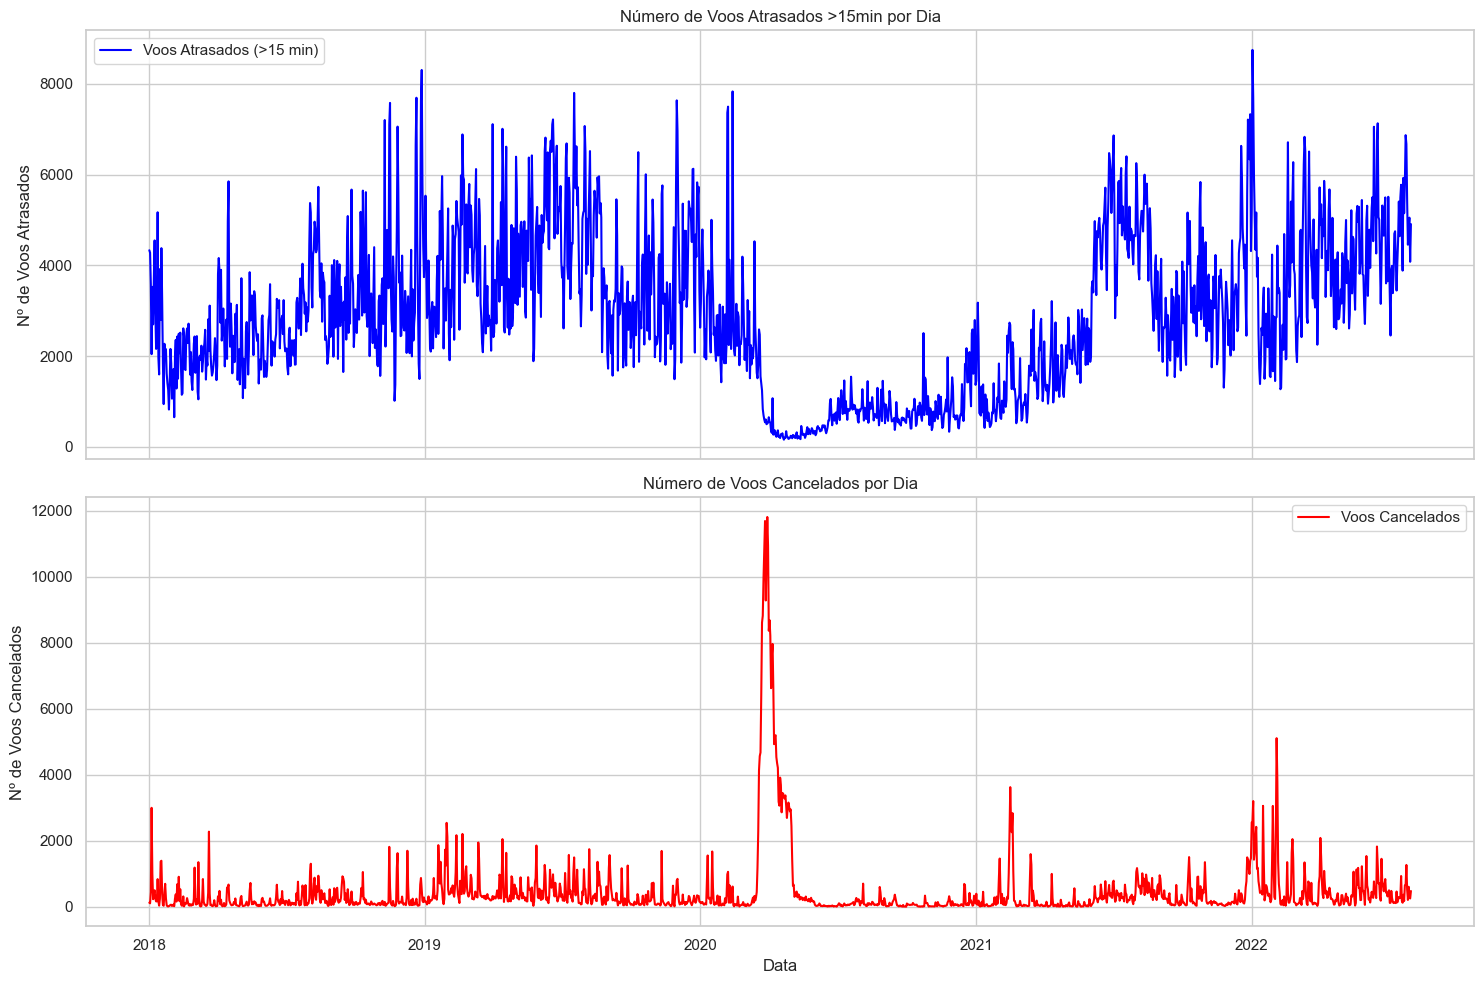

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Série de Atrasos
axs[0].plot(series_diarias.index, series_diarias["Atrasos"], label="Voos Atrasados (>15 min)", color='blue')
axs[0].set_title("Número de Voos Atrasados >15min por Dia")
axs[0].set_ylabel("Nº de Voos Atrasados")
axs[0].legend()

# Série de Cancelamentos
axs[1].plot(series_diarias.index, series_diarias["Cancelamentos"], label="Voos Cancelados", color='red')
axs[1].set_title("Número de Voos Cancelados por Dia")
axs[1].set_ylabel("Nº de Voos Cancelados")
axs[1].legend()

plt.xlabel("Data")
plt.tight_layout()
plt.show()

### 🔍 Análise de Tendência, Sazonalidade e Ruído

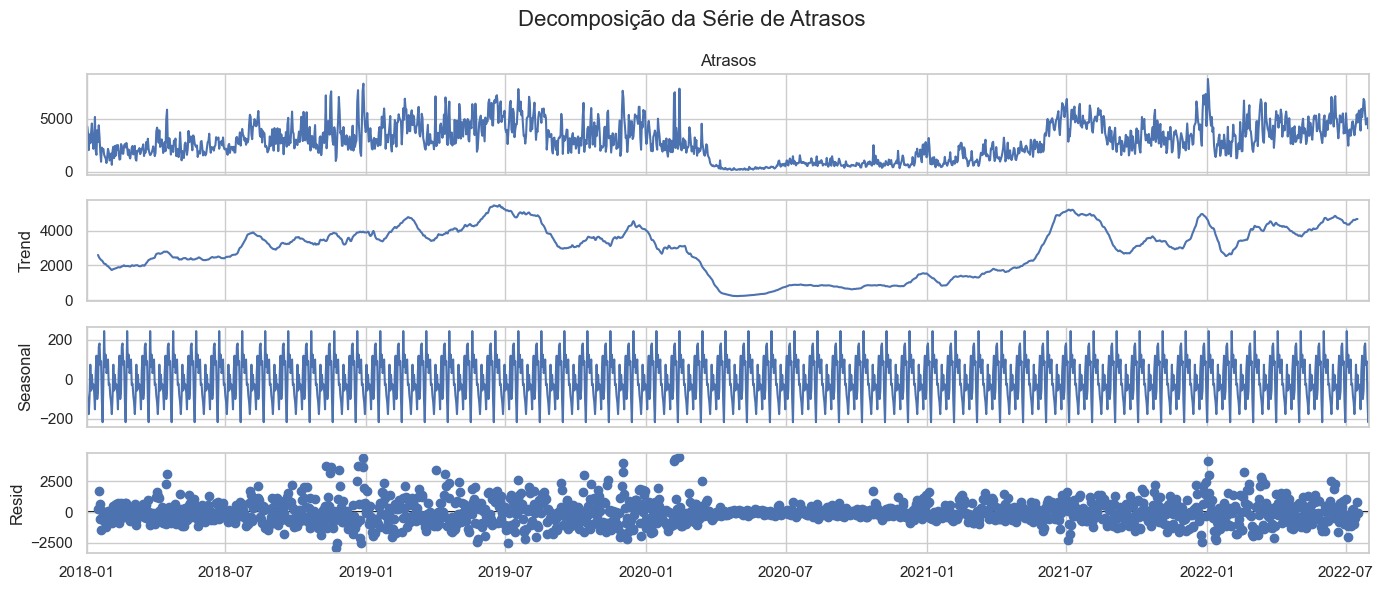

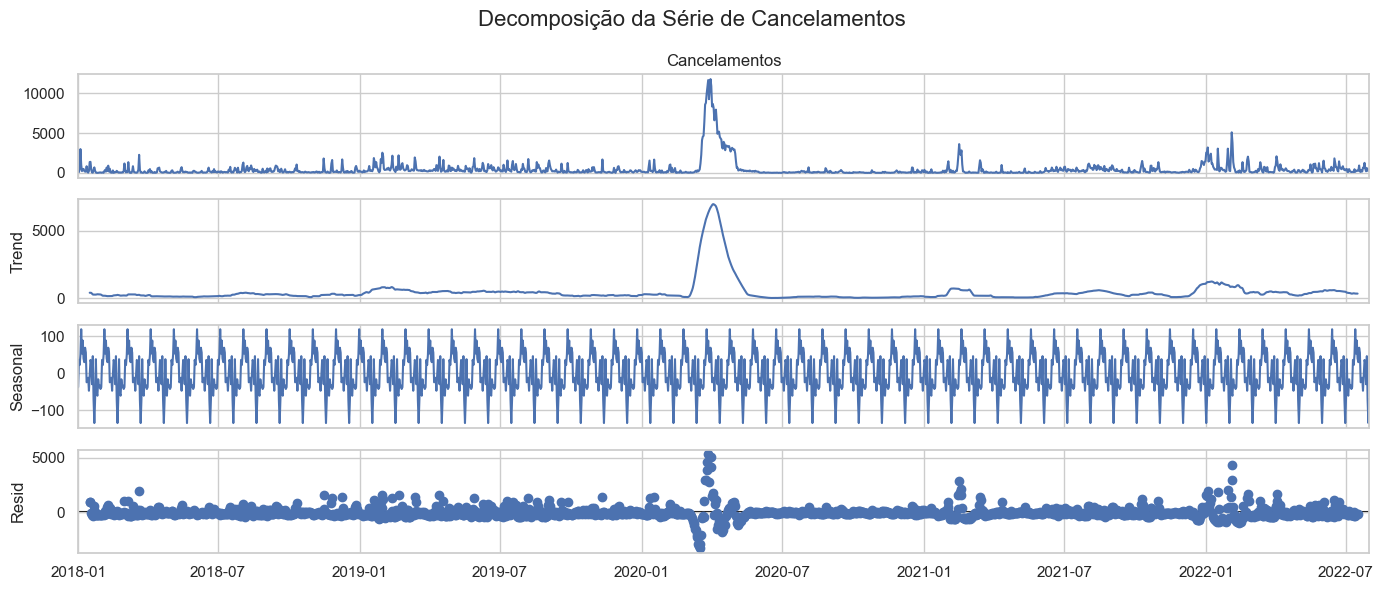

In [10]:
# Decomposição das séries
decomposicao_atrasos = seasonal_decompose(series_diarias["Atrasos"], model="additive", period=30)
decomposicao_cancelamentos = seasonal_decompose(series_diarias["Cancelamentos"], model="additive", period=30)

# Visualizar decomposição - Atrasos
decomposicao_atrasos.plot()
plt.suptitle("Decomposição da Série de Atrasos", fontsize=16)
plt.tight_layout()
plt.show()

# Visualizar decomposição - Cancelamentos
decomposicao_cancelamentos.plot()
plt.suptitle("Decomposição da Série de Cancelamentos", fontsize=16)
plt.tight_layout()
plt.show()

### ⚡ Análise de Quebras de Estrutura

> Primeiramente, para detetar quebras de estrutura, usamos uma abordagem visual, aplicando uma média móvel para suavizar e destacar mudanças bruscas de seguida aplicamos o teste CUSUM para detectar formalmente as quebras.

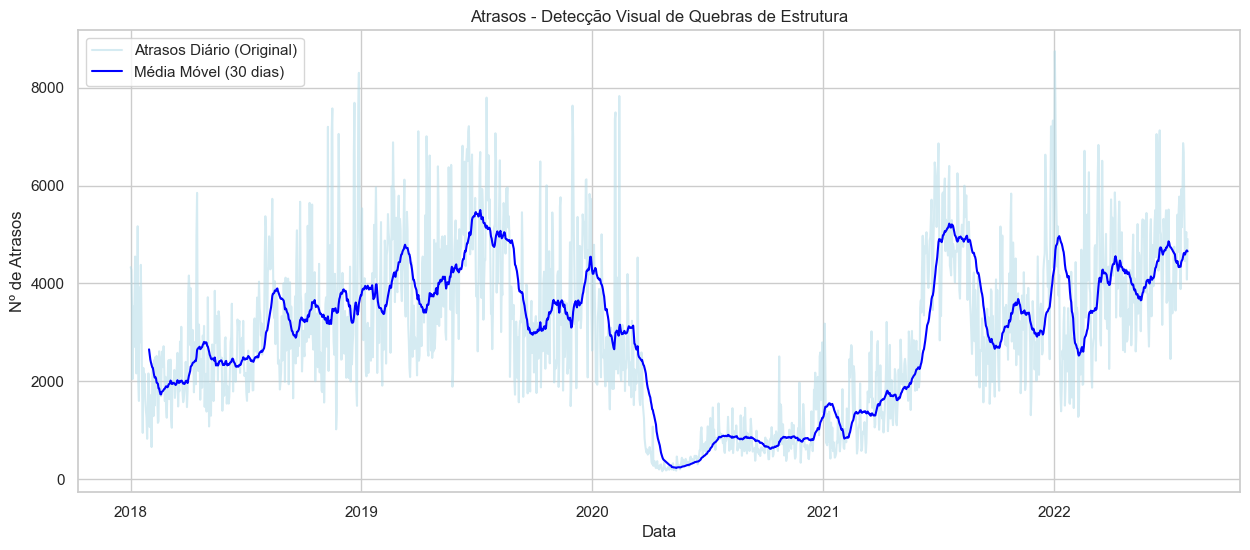

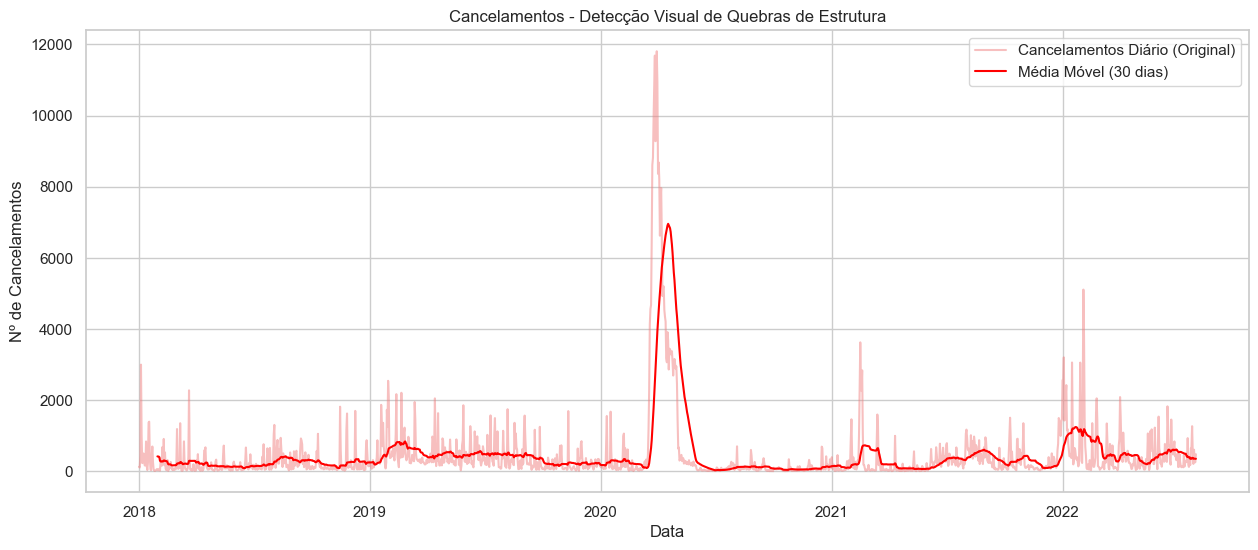

In [11]:
# Cálculo da média móvel (rolling mean) de 30 dias
series_diarias["Atrasos_MM30"] = series_diarias["Atrasos"].rolling(window=30).mean()
series_diarias["Cancelamentos_MM30"] = series_diarias["Cancelamentos"].rolling(window=30).mean()

# Plot comparativo - Atrasos
plt.figure(figsize=(15,6))
plt.plot(series_diarias.index, series_diarias["Atrasos"], color="lightblue", label="Atrasos Diário (Original)", alpha=0.5)
plt.plot(series_diarias.index, series_diarias["Atrasos_MM30"], color="blue", label="Média Móvel (30 dias)")
plt.title("Atrasos - Detecção Visual de Quebras de Estrutura")
plt.xlabel("Data")
plt.ylabel("Nº de Atrasos")
plt.legend()
plt.show()

# Plot comparativo - Cancelamentos
plt.figure(figsize=(15,6))
plt.plot(series_diarias.index, series_diarias["Cancelamentos"], color="lightcoral", label="Cancelamentos Diário (Original)", alpha=0.5)
plt.plot(series_diarias.index, series_diarias["Cancelamentos_MM30"], color="red", label="Média Móvel (30 dias)")
plt.title("Cancelamentos - Detecção Visual de Quebras de Estrutura")
plt.xlabel("Data")
plt.ylabel("Nº de Cancelamentos")
plt.legend()
plt.show()

### ⚡ Teste de Quebras de Estrutura com CUSUM

In [12]:
# Função para rodar CUSUM
def aplicar_cusum(serie, nome_serie):
    serie = serie.dropna()
    modelo = sm.OLS(serie, sm.add_constant(np.arange(len(serie)))).fit()
    cusum = breaks_cusumolsresid(modelo.resid, ddof=1)
    print(f"Teste CUSUM para {nome_serie}:")
    print(f"Estatística: {cusum[0]:.4f}")
    print(f"p-valor: {cusum[1]:.4f}")
    if cusum[1] < 0.05:
        print(f"➡️ Existe evidência de quebra de estrutura em {nome_serie}!\n")
    else:
        print(f"➡️ Não há evidência significativa de quebra de estrutura em {nome_serie}.\n")

# Aplicar para atrasos
aplicar_cusum(series_diarias["Atrasos"], "Atrasos")

# Aplicar para cancelamentos
aplicar_cusum(series_diarias["Cancelamentos"], "Cancelamentos")

Teste CUSUM para Atrasos:
Estatística: 6.6362
p-valor: 0.0000
➡️ Existe evidência de quebra de estrutura em Atrasos!

Teste CUSUM para Cancelamentos:
Estatística: 3.3082
p-valor: 0.0000
➡️ Existe evidência de quebra de estrutura em Cancelamentos!



# ✅ Conclusões até aqui: para ir para o relatório

## Descrição das Séries Temporais

Foram analisadas duas séries temporais relativas a voos nos Estados Unidos, no período compreendido entre **2018 e julho de 2022**:
- **Número de Voos Atrasados (>15 minutos) por dia**;
- **Número de Voos Cancelados por dia**.

As séries foram previamente agregadas por data de voo (`FlightDate`) e analisadas individualmente. A ampliação do período histórico permitiu identificar padrões mais consistentes e avaliar efeitos estruturais de eventos globais como a pandemia da COVID-19.

A visualização gráfica inicial revelou diferenças marcantes entre as duas séries:
- A série de **atrasos** apresenta um comportamento contínuo, com flutuações regulares, forte presença de sazonalidade e uma recuperação pós-COVID notavelmente visível.
- A série de **cancelamentos** é mais esparsa, marcada por valores baixos na maioria dos dias, intercalados com picos abruptos altamente concentrados, refletindo a sensibilidade a eventos disruptivos.

## Análise de Tendência, Sazonalidade e Ruído

Foi realizada uma decomposição aditiva das séries em três componentes:

- **Tendência**: Observam-se movimentos cíclicos claros ao longo dos anos. Nos atrasos, há uma queda significativa em 2020 (durante o auge da pandemia) e posterior recuperação. Nos cancelamentos, destaca-se o pico extremo no início de 2020.
- **Sazonalidade**: Há padrões semanais bem definidos, especialmente nos atrasos, com maior número de voos em certos dias da semana e em épocas do ano (ex. verão, fim de ano).
- **Ruído (Resíduo)**: Ambas as séries contêm variações não explicadas pelos componentes principais. Essa variabilidade residual é mais pronunciada nos cancelamentos, indicando alta imprevisibilidade em dias específicos.

## Análise de Quebras de Estrutura

A avaliação das quebras estruturais foi conduzida por duas abordagens complementares:

### 1. Inspeção Visual

A suavização com média móvel de 30 dias permitiu destacar padrões e rupturas claras:
- **Atrasos**: quedas abruptas no início de 2020, com recuperação gradual a partir de 2021.
- **Cancelamentos**: picos extraordinários entre março e abril de 2020 (coincidindo com o início da pandemia), além de novas oscilações durante os invernos de 2021 e 2022.

### 2. Teste Formal - CUSUM

Foi aplicado o teste estatístico CUSUM para deteção formal de quebras de estrutura:

| Série           | Estatística CUSUM | p-valor | Evidência de Quebra |
|------------------|------------------|---------|----------------------|
| Atrasos          | 6.6362           | 0.0000  | Sim                  |
| Cancelamentos    | 3.3082           | 0.0000  | Sim                  |

Ambas as séries apresentam **evidência estatística forte** de quebras estruturais, confirmando a presença de mudanças de regime.

## Considerações Finais

A análise exploratória demonstrou que:
- As séries de atrasos e cancelamentos possuem comportamentos temporais distintos, tanto em padrão como em variabilidade.
- Foram identificadas tendências sazonais e estruturais claras, bem como a presença de ruído e outliers significativos.
- Há **fortes evidências de quebras de estrutura**, associadas a eventos externos (como a pandemia e fenómenos meteorológicos extremos).

Estas características reforçam a necessidade de empregar **modelos de previsão capazes de lidar com sazonalidade, rupturas e não-linearidades** — tema que será aprofundado na próxima etapa do projeto (modelação e previsão).

# 2. Análise Inferencial:

### 🧪 Testes de Normalidade

In [13]:
# Teste de normalidade - Atrasos
stat_atrasos, p_atrasos = normaltest(series_diarias["Atrasos"])
print(f"Teste de Normalidade (Atrasos): Estatística = {stat_atrasos:.4f}, p-valor = {p_atrasos:.4f}")
if p_atrasos < 0.05:
    print("Conclusão: rejeitamos H0 → a série de Atrasos NÃO segue uma distribuição normal.\n")
else:
    print("Conclusão: não rejeitamos H0 → a série de Atrasos segue uma distribuição normal.\n")

# Teste de normalidade - Cancelamentos
stat_cancel, p_cancel = normaltest(series_diarias["Cancelamentos"])
print(f"Teste de Normalidade (Cancelamentos): Estatística = {stat_cancel:.4f}, p-valor = {p_cancel:.4f}")
if p_cancel < 0.05:
    print("Conclusão: rejeitamos H0 → a série de Cancelamentos NÃO segue uma distribuição normal.\n")
else:
    print("Conclusão: não rejeitamos H0 → a série de Cancelamentos segue uma distribuição normal.\n")

Teste de Normalidade (Atrasos): Estatística = 62.4171, p-valor = 0.0000
Conclusão: rejeitamos H0 → a série de Atrasos NÃO segue uma distribuição normal.

Teste de Normalidade (Cancelamentos): Estatística = 2003.4928, p-valor = 0.0000
Conclusão: rejeitamos H0 → a série de Cancelamentos NÃO segue uma distribuição normal.



### 📉 Testes de Estacionariedade (ADF)

In [14]:
# Teste ADF - Atrasos
resultado_adf_atrasos = adfuller(series_diarias["Atrasos"])
print("Teste ADF - Atrasos")
print(f"Estatística: {resultado_adf_atrasos[0]:.4f}")
print(f"p-valor: {resultado_adf_atrasos[1]:.4f}")
if resultado_adf_atrasos[1] < 0.05:
    print("Conclusão: rejeitamos H0 → a série de Atrasos é estacionária.\n")
else:
    print("Conclusão: não rejeitamos H0 → a série de Atrasos NÃO é estacionária.\n")

# Teste ADF - Cancelamentos
resultado_adf_cancel = adfuller(series_diarias["Cancelamentos"])
print("Teste ADF - Cancelamentos")
print(f"Estatística: {resultado_adf_cancel[0]:.4f}")
print(f"p-valor: {resultado_adf_cancel[1]:.4f}")
if resultado_adf_cancel[1] < 0.05:
    print("Conclusão: rejeitamos H0 → a série de Cancelamentos é estacionária.\n")
else:
    print("Conclusão: não rejeitamos H0 → a série de Cancelamentos NÃO é estacionária.\n")

Teste ADF - Atrasos
Estatística: -2.6489
p-valor: 0.0833
Conclusão: não rejeitamos H0 → a série de Atrasos NÃO é estacionária.

Teste ADF - Cancelamentos
Estatística: -5.5789
p-valor: 0.0000
Conclusão: rejeitamos H0 → a série de Cancelamentos é estacionária.



### 📉 Testes de Estacionariedade (KPSS)

In [15]:
def testar_kpss(serie, nome_serie):
    print(f"Teste KPSS - {nome_serie}")
    stat, p_valor, _, criticos = kpss(serie, regression='c')
    print(f"Estatística: {stat:.4f}")
    print(f"p-valor: {p_valor:.4f}")
    if p_valor < 0.05:
        print(f"Rejeitamos H₀ ➔ A série {nome_serie} NÃO é estacionária.\n")
    else:
        print(f"Não rejeitamos H₀ ➔ A série {nome_serie} é estacionária.\n")

# Aplicar aos dados
testar_kpss(series_diarias["Atrasos"], "Atrasos")
testar_kpss(series_diarias["Cancelamentos"], "Cancelamentos")

Teste KPSS - Atrasos
Estatística: 0.6739
p-valor: 0.0159
Rejeitamos H₀ ➔ A série Atrasos NÃO é estacionária.

Teste KPSS - Cancelamentos
Estatística: 0.1070
p-valor: 0.1000
Não rejeitamos H₀ ➔ A série Cancelamentos é estacionária.



/var/folders/0n/k3c3l48s6lnbht8rztkmm8f00000gn/T/ipykernel_25700/4124670216.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p_valor, _, criticos = kpss(serie, regression='c')


### 🔁 Diferenciação da série dos Atrasos (d=1)

In [16]:
from statsmodels.tsa.stattools import adfuller, kpss

# Aplicar 1ª diferença
atrasos_diff = series_diarias["Atrasos"].diff().dropna()

# Teste ADF na série diferenciada
resultado_adf_diff = adfuller(atrasos_diff)
print("Teste ADF - Atrasos (diferenciada)")
print(f"Estatística: {resultado_adf_diff[0]:.4f}")
print(f"p-valor: {resultado_adf_diff[1]:.4f}")
if resultado_adf_diff[1] < 0.05:
    print("Rejeitamos H0 ➔ A série diferenciada de Atrasos é estacionária.\n")
else:
    print("Não rejeitamos H0 ➔ A série diferenciada de Atrasos ainda NÃO é estacionária.\n")

# Teste KPSS na série diferenciada
stat_kpss, p_kpss, _, _ = kpss(atrasos_diff, regression='c')
print("Teste KPSS - Atrasos (diferenciada)")
print(f"Estatística: {stat_kpss:.4f}")
print(f"p-valor: {p_kpss:.4f}")
if p_kpss < 0.05:
    print("Rejeitamos H₀ ➔ A série diferenciada de Atrasos NÃO é estacionária.\n")
else:
    print("Não rejeitamos H₀ ➔ A série diferenciada de Atrasos é estacionária.\n")

Teste ADF - Atrasos (diferenciada)
Estatística: -11.9672
p-valor: 0.0000
Rejeitamos H0 ➔ A série diferenciada de Atrasos é estacionária.

Teste KPSS - Atrasos (diferenciada)
Estatística: 0.0775
p-valor: 0.1000
Não rejeitamos H₀ ➔ A série diferenciada de Atrasos é estacionária.



/var/folders/0n/k3c3l48s6lnbht8rztkmm8f00000gn/T/ipykernel_25700/1408118435.py:17: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat_kpss, p_kpss, _, _ = kpss(atrasos_diff, regression='c')


In [17]:
atrasos_diff.head()

FlightDate
2018-01-02     -54.0
2018-01-03    -701.0
2018-01-04   -1533.0
2018-01-05    1482.0
2018-01-06    -827.0
Name: Atrasos, dtype: float64

### 🔗 Testes de Autocorrelação

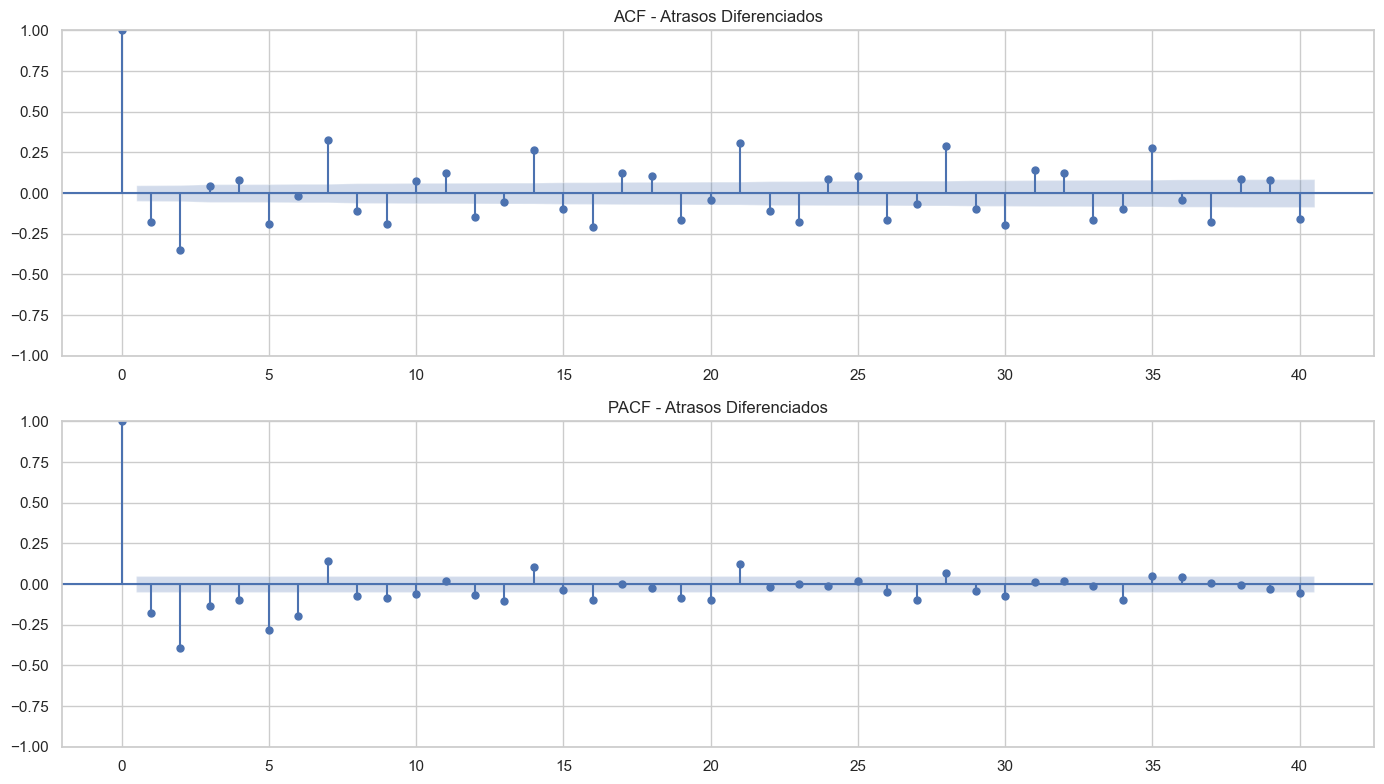

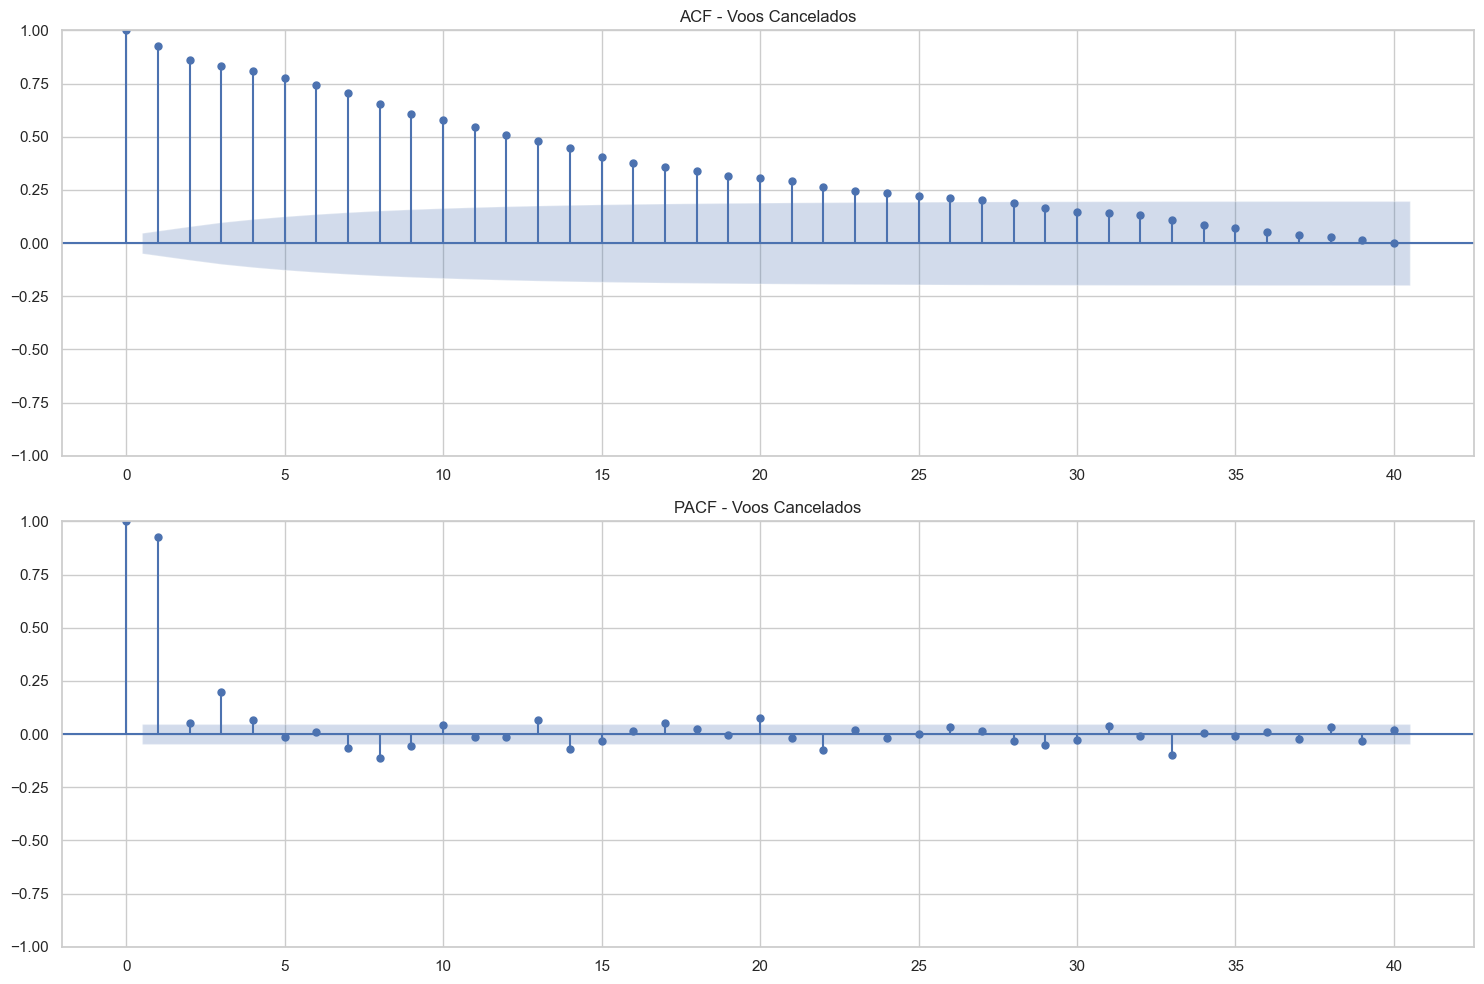

In [18]:
# Plot ACF e PACF
fig, axs = plt.subplots(2, 1, figsize=(14, 8))
plot_acf(atrasos_diff, lags=40, ax=axs[0])
axs[0].set_title("ACF - Atrasos Diferenciados")
plot_pacf(atrasos_diff, lags=40, ax=axs[1])
axs[1].set_title("PACF - Atrasos Diferenciados")
plt.tight_layout()
plt.show()

# Gráfico ACF e PACF para Cancelamentos
fig, axs = plt.subplots(2, 1, figsize=(15,10))
plot_acf(series_diarias["Cancelamentos"], ax=axs[0], lags=40)
axs[0].set_title("ACF - Voos Cancelados")
plot_pacf(series_diarias["Cancelamentos"], ax=axs[1], lags=40)
axs[1].set_title("PACF - Voos Cancelados")
plt.tight_layout()
plt.show()

### 🔗 Teste de Independência com Ljung-Box

In [19]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Teste de Ljung-Box
print("Teste de Ljung-Box - Série Atrasos Diferenciada")
ljung_diff = acorr_ljungbox(atrasos_diff, lags=[20], return_df=True)
print(f"Estatística: {ljung_diff['lb_stat'].values[0]:.4f}")
print(f"p-valor: {ljung_diff['lb_pvalue'].values[0]:.4f}")
if ljung_diff['lb_pvalue'].values[0] < 0.05:
    print("Rejeitamos H0 ➔ Existe autocorrelação → A série diferenciada NÃO é independente.\n")
else:
    print("Não rejeitamos H0 ➔ Não há autocorrelação significativa → Série diferenciada é independente.\n")

# Teste Ljung-Box para Cancelamentos
lb_cancel = acorr_ljungbox(series_diarias["Cancelamentos"], lags=[20], return_df=True)
print("Teste Ljung-Box - Cancelamentos")
print(f"Estatística: {lb_cancel['lb_stat'].values[0]:.4f}")
print(f"p-valor: {lb_cancel['lb_pvalue'].values[0]:.4f}")
if lb_cancel['lb_pvalue'].values[0] < 0.05:
    print("Conclusão: rejeitamos H0 → Existe autocorrelação → a série de Cancelamentos NÃO é independente.\n")
else:
    print("Conclusão: não rejeitamos H0 → não há evidências de autocorrelação → a série de Cancelamentos é independente.\n")

Teste de Ljung-Box - Série Atrasos Diferenciada
Estatística: 971.1522
p-valor: 0.0000
Rejeitamos H0 ➔ Existe autocorrelação → A série diferenciada NÃO é independente.

Teste Ljung-Box - Cancelamentos
Estatística: 12544.2199
p-valor: 0.0000
Conclusão: rejeitamos H0 → Existe autocorrelação → a série de Cancelamentos NÃO é independente.



### Guardar o dataset estacionário para a causalidade

In [22]:


# Carregar o dataset original
df_voos = pd.read_csv("../../data/flight-delay-dataset-2018-2022_Final.csv", parse_dates=['FlightDate'])
df_voos.set_index('FlightDate', inplace=True)

# Substituir a coluna original de Atrasos pela versão diferenciada que já tens
df_voos = df_voos.copy()
df_voos['Atrasos'] = atrasos_diff

# Remover a primeira linha com NaN da diff
df_voos = df_voos.dropna()
df_voos.head()


,Atrasos,Cancelamentos
FlightDate,,
2018-01-02,-54.0,110
2018-01-03,-701.0,449
2018-01-04,-1533.0,3001
2018-01-05,1482.0,1007
2018-01-06,-827.0,234


In [23]:
# Guardar no CSV para análise de causalidade
df_voos.to_csv("../../data/causality-dataset-2018-2022_Final.csv")
print("CSV salvo: Atrasos já diferenciados, Cancelamentos como estão.")

CSV salvo: Atrasos já diferenciados, Cancelamentos como estão.


# ✅ Conclusões até aqui: para ir para o relatório

## 1. Normalidade

- **Atrasos Diários**:
  - Estatística = 62.4171, p-valor = 0.0000  
  - **Conclusão**: Rejeitamos H₀ ➔ A série de atrasos **não segue** uma distribuição normal.

- **Cancelamentos Diários**:
  - Estatística = 2003.4928, p-valor = 0.0000  
  - **Conclusão**: Rejeitamos H₀ ➔ A série de cancelamentos **não segue** uma distribuição normal.

---

## 2. Estacionariedade

- **Atrasos Diários (original)**:
  - ADF: p-valor = 0.0833  
  - KPSS: p-valor = 0.0159  
  - **Conclusão**: Ambos os testes indicam que a série **não é estacionária**.

- **Atrasos Diários (diferenciada)**:
  - ADF: p-valor = 0.0000  
  - KPSS: p-valor = 0.1000  
  - **Conclusão**: Após aplicar a 1ª diferença, a série torna-se **estacionária**.

- **Cancelamentos Diários**:
  - ADF: p-valor = 0.0000  
  - KPSS: p-valor = 0.1000  
  - **Conclusão**: A série de cancelamentos é **estacionária sem necessidade de transformação**.

---

## 3. Independência

- **Atrasos Diários (diferenciada)**:
  - Estatística Ljung-Box = 14040.5810, p-valor = 0.0000  
  - **Conclusão**: Rejeitamos H₀ ➔ A série **não é independente**, apresentando autocorrelações.

- **Cancelamentos Diários**:
  - Estatística Ljung-Box = 12544.2199, p-valor = 0.0000  
  - **Conclusão**: Rejeitamos H₀ ➔ A série **não é independente**, apresentando autocorrelações.

---

## 4. Análise Gráfica (ACF e PACF)

- **Atrasos (diferenciada)**:
  - ACF com decaimento gradual, evidenciando dependência de curto e médio prazo.
  - PACF com picos nos primeiros lags, sugerindo estrutura autoregressiva.

- **Cancelamentos**:
  - ACF com padrão de decaimento mais rápido.
  - PACF com picos apenas nos lags iniciais, compatível com processos tipo MA(1) ou ARMA(1,1).

---

## 📌 Resumo Final da EDA

A análise exploratória das séries temporais revelou comportamentos típicos de dados operacionais reais, com assimetrias fortes, outliers relevantes e padrões de autocorrelação.

- Ambas as séries são **não normais** e apresentam **dependência temporal** significativa.
- A série de **cancelamentos** é estacionária por natureza.
- A série de **atrasos exigiu diferenciação** para atingir estacionariedade — o que foi confirmado pelos testes ADF e KPSS após a transformação.

Estes resultados validam a abordagem de modelação clássica e abrem caminho para a comparação com métodos de deep learning na próxima fase do projeto.